# Load Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
## Customization Options
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'
## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

import joblib

import shap
from lime.lime_tabular import LimeTabularExplainer

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
loaded_joblib = joblib.load('Data/best_models.joblib')
loaded_joblib.keys()

dict_keys(['X_train_df', 'y_train_', 'X_test_df', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForest'])

In [3]:
X_train = loaded_joblib['X_train_df']
y_train = loaded_joblib['y_train_']
X_test = loaded_joblib['X_test_df']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
rf_reg = loaded_joblib['RandomForest']

In [4]:
X_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
print(f"Training R^2: {rf_reg.score(X_train,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test, y_test):.3f}")

Training R^2: 0.937
Test R^2: 0.546


# Applying Shap

In [6]:
shap.initjs()

In [7]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train, nsamples=400, random_state=321)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
3888,15.85,0.110653,36.9506,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2497,15.10,0.087407,221.8456,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7723,17.50,0.015592,184.8266,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8117,10.80,0.049820,243.2144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7475,15.00,0.044999,140.4838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Model Explainer

In [8]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap)

# Shap Values

In [9]:
shap_values[0]

.values =
array([ 6.87077817e-01, -2.39661468e+00, -1.65242139e+03, -2.12546161e+00,
        2.41471128e+00, -8.48893527e-01, -5.50855055e-01, -1.00607498e+00,
       -1.21695192e+00,  3.91177975e-01,  8.95091753e+00, -2.11190814e+00,
       -7.45193980e-01, -4.86367452e+00, -1.41695922e-01, -6.47087172e-01,
       -1.31268079e+00, -1.07965221e+00, -1.78809036e+00, -2.96709440e+00,
        5.23720295e-01, -3.30697164e+00, -1.84151137e+00,  4.86925106e-03,
       -8.10768492e-01, -3.58656271e+00,  4.89764994e+00,  2.52709240e+00,
        1.65233223e+02,  7.41127538e+00,  1.03788005e+01, -9.36510270e+01])

.base_values =
array([2207.5242624])

.data =
array([15.85      ,  0.11065338, 36.9506    ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.     

# Summary Bar Plots

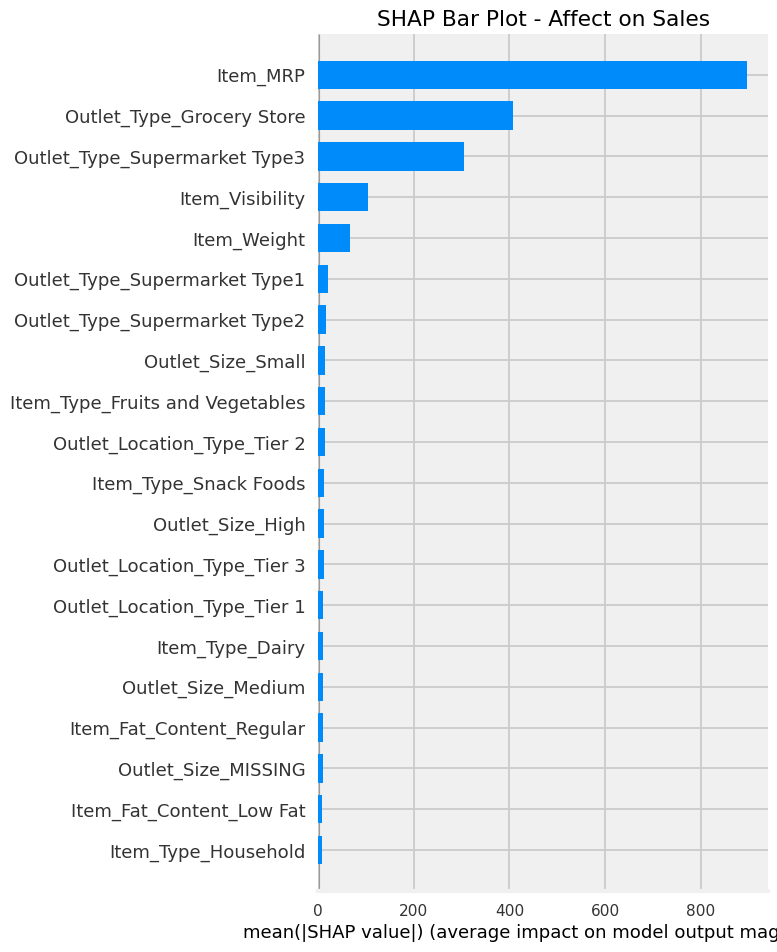

In [10]:
## create a summary plot (bar version)
fig, ax = plt.subplots()

shap.summary_plot(shap_values,features= X_shap, plot_type='bar', show=False)

plt.title('SHAP Bar Plot - Affect on Sales')

fig.savefig('Data/summary_plot_bar_rf_reg.png', dpi=70, bbox_inches='tight')

**Feature imporantance**

<img src = "Data/feature_importances.png" width=80% >

## SHAP vs. Feature Importances

- SHAP and Feature Importances show the same top 5 features

**Similarities:**
- Both the SHAP bar plot and feature importances show Item_MRP and Outlet_Type_Grocery Store as the top features

**Differences:**
- The SHAP bar plot shows Outlet_Type_Supermarket Type3 as 3rd most important feature while the same feature ranks 4th on the Feature Importances
- Item_Visibility ranks 4th on the SHAP bar while it ranks 3rd on the Feature Importances

# Summary Dot Plot

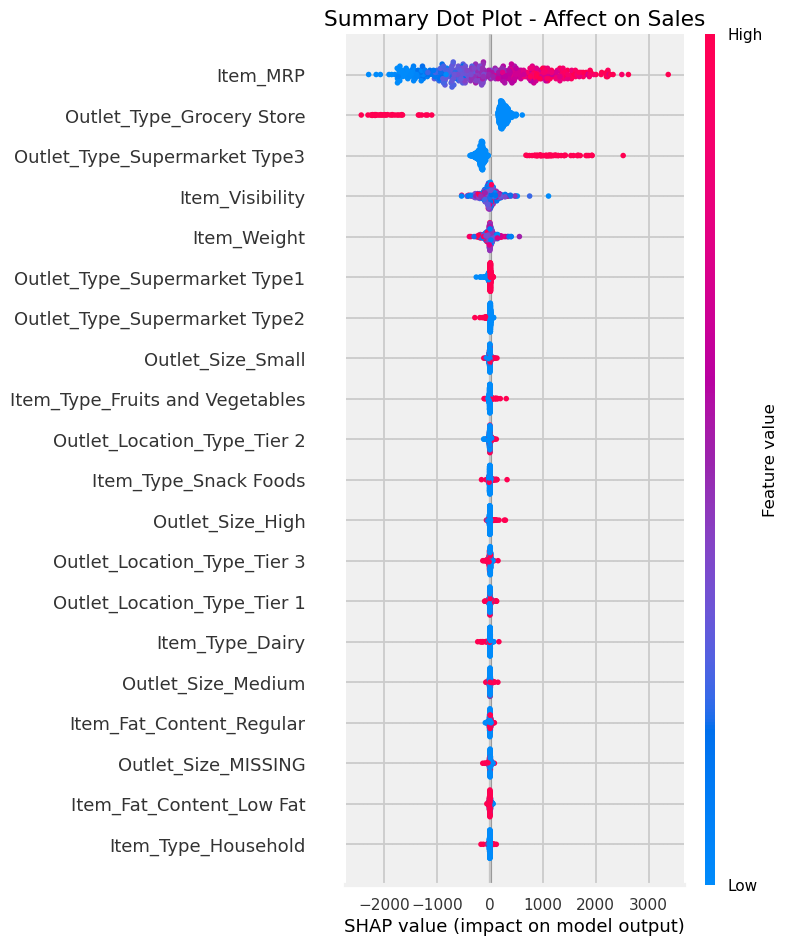

In [11]:
## create a summary plot (dot/default version)
fig, ax = plt.subplots()

shap.summary_plot(shap_values, features=X_shap, show=False)

plt.title('Summary Dot Plot - Affect on Sales')

fig.savefig("Data/summary_plot_dot_rf_reg.png", dpi=70, bbox_inches='tight')
plt.show()

**Summary Dot Plot Interpretation - Top 3 most important features**
- Item_MRP
    - The higher the item MRP (maximum retail price) the higher the predicted sales
- Outlet_Type_Grocery Store
    - a higher number of outlet type grocery stores decreases predicted sales 
- Outlet_Type_Supermarket Type3
    - as the number of outlet type supermarket type 3 increases the higher the sales predicted

# Local Explanations

In [12]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,15.85,0.110653,36.9506,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,15.10,0.087407,221.8456,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,17.50,0.015592,184.8266,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,10.80,0.049820,243.2144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,15.00,0.044999,140.4838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Finding a Meaningful Example to Explain

In [13]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count    400.000000
mean     146.899303
std       64.290200
min       32.055800
25%       98.821300
50%      144.028600
75%      195.711000
max      265.222600
Name: Item_MRP, dtype: float64

## Selecting Outlets Based on High and Low Sales

- Will select a store that had a high sales and one with low sales to compare

In [14]:
# Selecting row with the highest sales
## saving the index of the highest sales
idx_high_price = X_shap_local['Item_MRP'].idxmax()
idx_high_price

171

In [15]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_price]

Item_Weight                         10.00000
Item_Visibility                      0.02588
Item_MRP                           265.22260
Item_Fat_Content_Low Fat             1.00000
Item_Fat_Content_Regular             0.00000
Item_Type_Baking Goods               0.00000
Item_Type_Breads                     0.00000
Item_Type_Breakfast                  0.00000
Item_Type_Canned                     1.00000
Item_Type_Dairy                      0.00000
Item_Type_Frozen Foods               0.00000
Item_Type_Fruits and Vegetables      0.00000
Item_Type_Hard Drinks                0.00000
Item_Type_Health and Hygiene         0.00000
Item_Type_Household                  0.00000
Item_Type_Meat                       0.00000
Item_Type_Others                     0.00000
Item_Type_Seafood                    0.00000
Item_Type_Snack Foods                0.00000
Item_Type_Soft Drinks                0.00000
Item_Type_Starchy Foods              0.00000
Outlet_Size_High                     0.00000
Outlet_Siz

In [16]:
## what was the actual price?
y_shap_local.iloc[idx_high_price]

5815.0972

# Shap Force Plot

**High Sales**

In [19]:
## plotting example force plot 
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[idx_high_price].values,
               features = X_shap_local.iloc[idx_high_price])

**Interpretation**
- a significant push toward the right indicates higher sales
- 265.2 of a list price of a product goes to sales
- major features: Outlet_Type_Grocery Store and Item_Visibility


- Outlet size is the feature that is driving the sales downward. 

**Low Sales**

In [22]:
## saving the index of the most deaths
idx_low_price = X_shap_local['Item_MRP'].idxmin()
idx_low_price

6

In [24]:
## plotting example force plot 
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[idx_low_price].values,
               features = X_shap_local.iloc[idx_low_price])

**Interpretation**
- a significant push to the left indicating lower sales
- 32.06 of a list price of a product goes to sales
- major feature: Outlet_Type_Supermarket Type3
- Outlet_Size_Small is the feature that is driving sales up

# LIME Tabular Explanation

**High Sales**

In [25]:
## Create a lime explainer with X_shap_local
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [30]:
## Use the lime explainer to explain the selected example used above 
exp_high = lime_explainer.explain_instance(X_shap_local.loc[idx_high_price],
                                      rf_reg.predict)
exp_high.show_in_notebook()

In [31]:
exp_high.save_to_file('Data/lime_high_sales.html')

In [34]:
high_sales_html = HTML('<iframe src="Data/lime_high_sales.html" width="710" height="550"></iframe>')
high_sales_html

- Predicted Value is 5198.55. 

Interpreting our Features with the 'negative' and 'positive' bar chart

    - Negative (lower sales). These are features that contribute to lower sales. Some of the features include:
        - Outlet_Type_Supermarket Type1
        - Item_Type_Soft Drinks
        - Outlet_Size_High
    - Positive (higher sales). These are features that contribute to higher sales. Some of the features include: 
        - Outlet_Type_Grocery Store
        - Item_MRP
        - Item_Type_Canned

**Low Sales**

In [36]:
## Use the lime explainer to explain the selected example used above 
exp_low = lime_explainer.explain_instance(X_shap_local.loc[idx_low_price],
                                      rf_reg.predict)
exp_low.show_in_notebook()

In [37]:
exp_low.save_to_file('Data/lime_low_sales.html')

In [38]:
low_sales_html = HTML('<iframe src="Data/lime_low_sales.html" width="710" height="550"></iframe>')
low_sales_html

- Predicted Value is 723.46. 

Interpreting our Features with the 'negative' and 'positive' bar chart

    - Negative (lower sales). These are features that contribute to lower sales. Some of the features include:
        - Item_MRP
        - Outlet_Type_Supermarket Type3
        - Item_Type_Starchy Foods
    - Positive (higher sales). These are features that contribute to higher sales. Some of the features include: 
        - Outlet_Type_Grocery Store
        - Outlet_Type_Supermarket Type1
        - Item_Type_Frozen Foods